## Single series forecasting with SARIMA
Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.
SARIMA (Seasonal Auto-Regressive Integrated Moving Average) is an extension of the ARIMA model that incorporates seasonality in addition to the non-seasonal components.

In [1]:
! pip3 install statsmodels

In [12]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('once')
%matplotlib inline 

#### Solar homes consumption

In [3]:
solar_data = pd.read_csv('./SolarMonthlyData_2657Custs.csv')
# Data preprocessing
# ======================================================================================
consumption_billrate = ['PK', 'LVP', 'SH', 'LVS','OP','OP1','OP2']
solar_data_consumption = solar_data[(solar_data['Netwk Bill Rate Type'].isin(consumption_billrate)) & (solar_data['Unit of me'] == 'KWH')].copy()
solar_data_consumption['Consumption Month'] = solar_data_consumption['Consumption Month'].apply(lambda x: "{:.4f}".format(x))
solar_data_consumption['Consumption Month'] = solar_data_consumption['Consumption Month'].astype('str')
solar_data_consumption['Consumption Month'] = pd.to_datetime(solar_data_consumption['Consumption Month'].apply(lambda x: dt.datetime.strptime(x, '%m.%Y')))
solar_data_consumption['house_type'] = 'solar'
solar_data_consumption.head()

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me,house_type
96,1,OP1,2007-01-01,168.073,KWH,solar
97,1,OP1,2008-01-01,145.746,KWH,solar
99,1,OP1,2009-01-01,189.888,KWH,solar
101,1,OP1,2010-01-01,163.563,KWH,solar
103,1,OP1,2011-01-01,176.308,KWH,solar


In [17]:
solar_data_consumption.isna().sum()

Customer ID             0
Netwk Bill Rate Type    0
Consumption Month       0
Sum                     0
Unit of me              0
house_type              0
dtype: int64

In [4]:
solar_data_grouped = solar_data_consumption.groupby(['Consumption Month']).agg(consumption = ('Sum','sum')).reset_index()
solar_data_grouped.columns = ['month', 'consumption']
solar_data_grouped.head()

,month,consumption
0,2007-01-01,419325.368
1,2007-02-01,386458.534
2,2007-03-01,464260.421
3,2007-04-01,492518.867
4,2007-05-01,588454.604


In [5]:
solar = solar_data_grouped.set_index('month')
solar.head()

,consumption
month,
2007-01-01,419325.368
2007-02-01,386458.534
2007-03-01,464260.421
2007-04-01,492518.867
2007-05-01,588454.604


##### Check for stationarity 

The Time series data model works on stationary data. The stationarity of data is described by the following three criteria:-

1) It should have a constant mean

2) It should have a constant variance

3) Auto covariance does not depend on the time

*Mean – it is the average value of all the data

*Variance – it is a difference of each point value from the mean

*Auto covariance –it is a relationship between any two values at a certain amount of time.

<Axes: xlabel='month'>

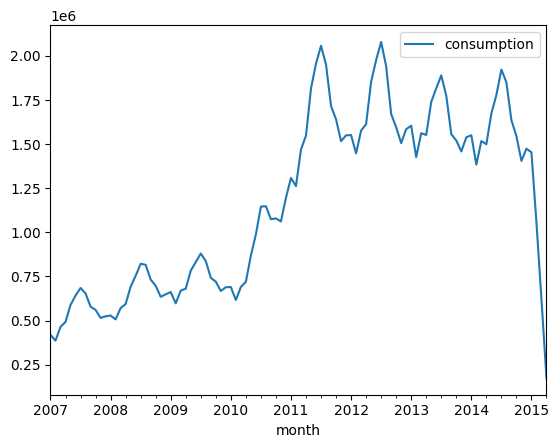

In [6]:
solar.plot()

The above plot shows trend and seasonality. So, it's Non-stationary

Let's try the ACDF test now. In this method, we take a null hypothesis that the data is non-stationary. If the test statistic is less than the critical value then we can reject the null hypothesis and say that the series is stationary.

In [15]:
# Augmented Dickey-fuller test

from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(solar['consumption'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                 -1.912055
p-value                         0.326412
#lags used                     12.000000
number of observations used    87.000000
critical value (1%)            -3.507853
critical value (5%)            -2.895382
critical value (10%)           -2.584824
dtype: float64


From the above, we see that the test statistic is greater than the critival value. Hence we fail to reject the Null hypothesis. So, the data is Non-stationary.

We can try another method called - Rolling statistics. 
This method gives a visual representation of the data to define its stationarity. A Moving variance or moving average graph is plot and then it is observed whether it varies with time or not. In this method, a moving window of time is taken (based on our needs, for eg-10, 12, etc.) and then the mean of that time period is calculated as the current value.

             consumption
month                   
2007-01-01           NaN
2007-02-01           NaN
2007-03-01           NaN
2007-04-01           NaN
2007-05-01           NaN
...                  ...
2014-12-01  1.602927e+06
2015-01-01  1.594853e+06
2015-02-01  1.567465e+06
2015-03-01  1.492676e+06
2015-04-01  1.382343e+06

[100 rows x 1 columns]               consumption
month                    
2007-01-01            NaN
2007-02-01            NaN
2007-03-01            NaN
2007-04-01            NaN
2007-05-01            NaN
...                   ...
2014-12-01  172666.168129
2015-01-01  177548.047431
2015-02-01  230513.831577
2015-03-01  358374.354823
2015-04-01  522412.389889

[100 rows x 1 columns]


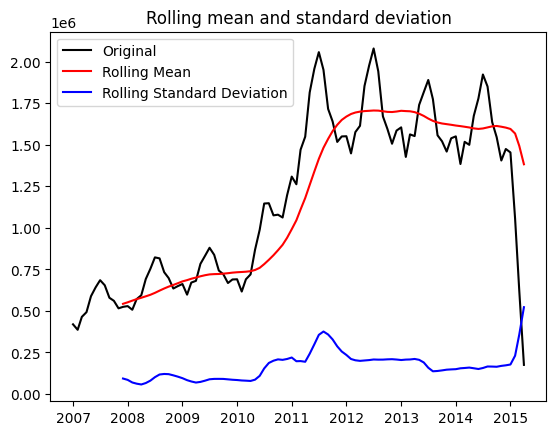

In [16]:
# Rolling statistics test

rmean=solar.rolling(window=12).mean()
rstd=solar.rolling(window=12).std()
print(rmean,rstd)
orig=plt.plot(solar , color='black',label='Original')
mean= plt.plot(rmean , color='red',label='Rolling Mean')
std=plt.plot(rstd,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.show(block=False)

From the above graph we can see that the rolling mean and rolling standard deviation are not constant. So, the series is non-strationary.

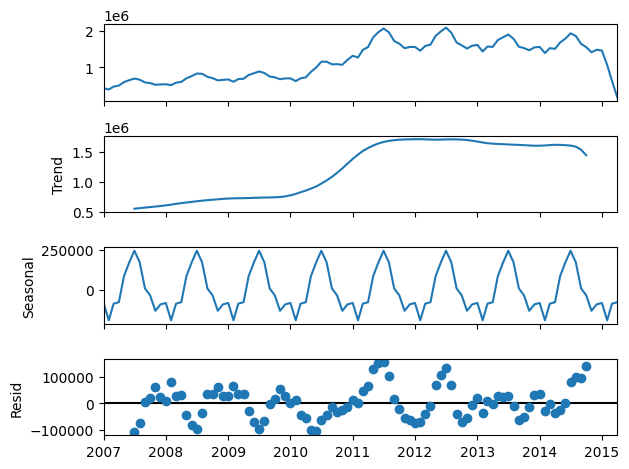

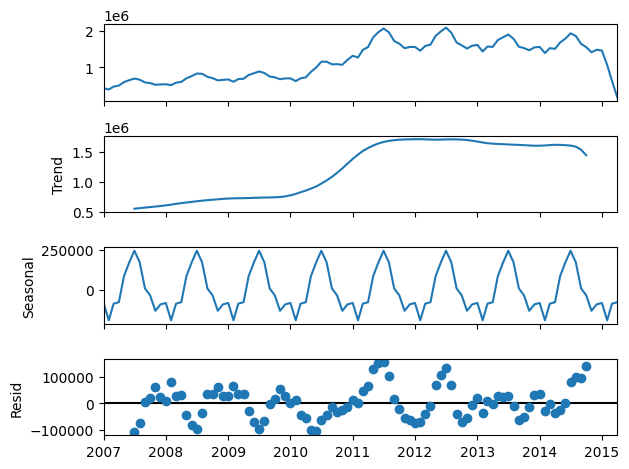

In [19]:
# First decompose the data
seasonal_decompose(solar, period=12, model='additive').plot()


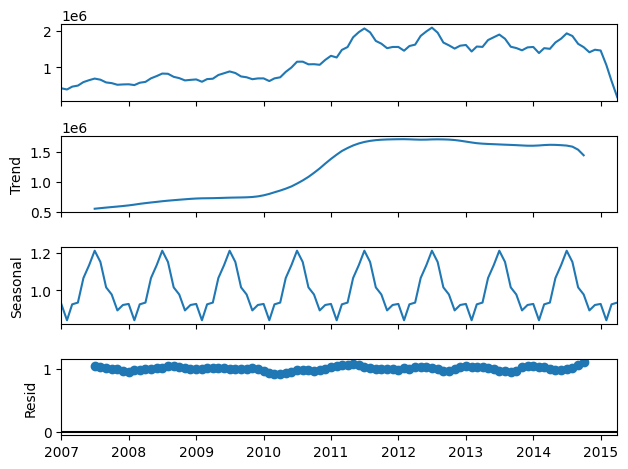

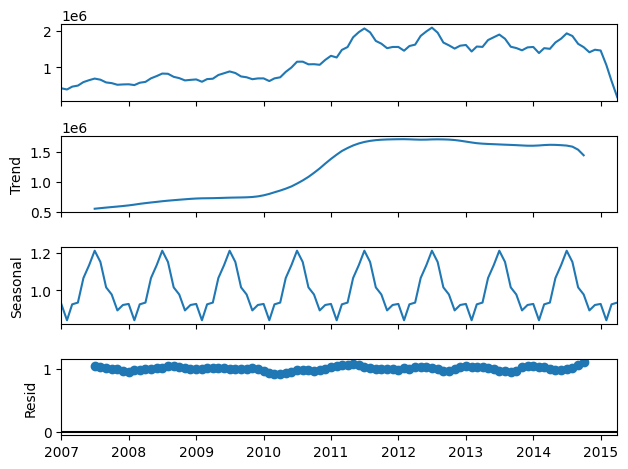

In [20]:
# Try multiplicative model if there is growth over time
seasonal_decompose(solar, period=12, model='multiplicative').plot()

The main differences between additive and multiplicative time-series is the following:
- Additive: amplitudes of seasonal effects are similar in each period.
- Multiplicative: seasonal trend changes with the progression of the time series.

For our data, a multiplicative model seems more apt, given the overall trend is increasing

ARIMA handles non-stationary data (the I in ARIMA stands for Integrated, which handles the procedure of making the time series stationary.

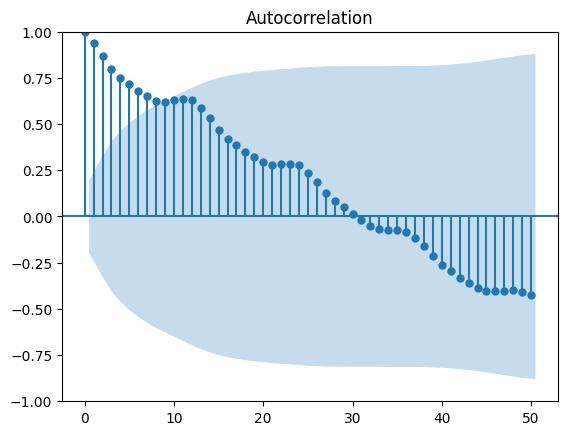

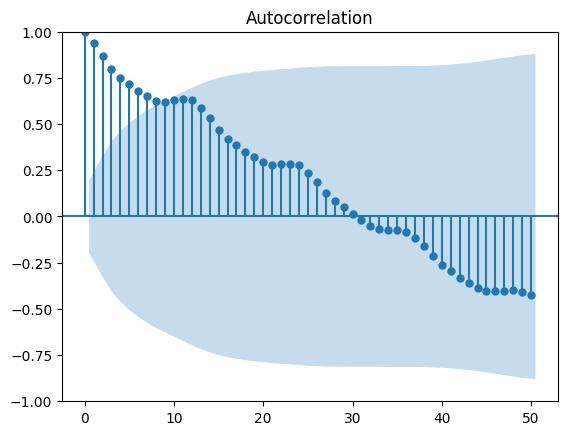

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(solar, lags=50)

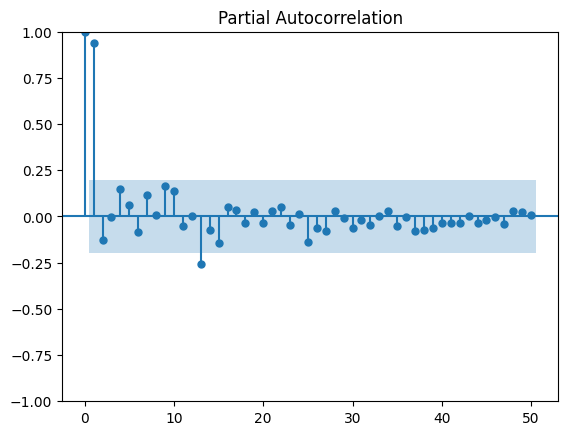

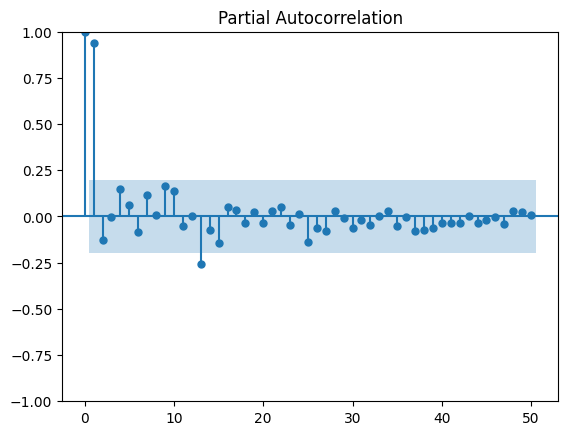

In [26]:
plot_pacf(solar, lags=50)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

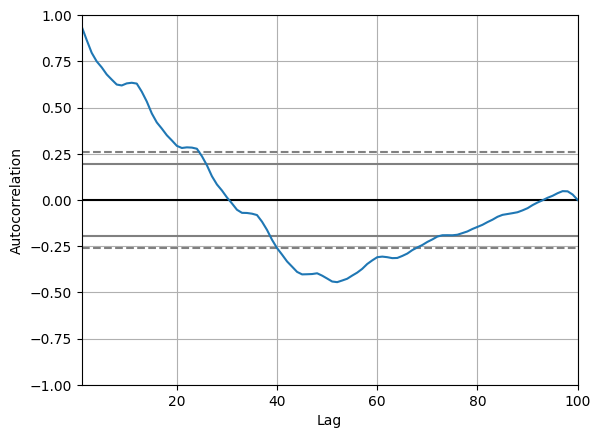

In [9]:
autocorrelation_plot(solar)

We can see that there is a positive correlation with the first 30 lags that is perhaps significant for the first 10 lags.

This provides a hint: initiating the AR parameter of our model with a value of 10 could be a beneficial starting point.

In [22]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2011-12-01'
end_val = '2013-12-01'

data_train = solar.loc[:end_train, :].copy()
data_val   = solar.loc[end_train:end_val, :].copy()
data_test  = solar.loc[end_val:, :].copy()
print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates      : 2007-01-01 00:00:00 --- 2011-12-01 00:00:00  (n=60)
Validation dates : 2011-12-01 00:00:00 --- 2013-12-01 00:00:00  (n=25)
Test dates       : 2013-12-01 00:00:00 --- 2015-04-01 00:00:00  (n=17)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08431D+01    |proj g|=  3.16159D+00

At iterate    5    f=  9.65488D+00    |proj g|=  3.23848D-01

At iterate   10    f=  9.58650D+00    |proj g|=  1.54549D-01

At iterate   15    f=  9.55259D+00    |proj g|=  5.45555D-02

At iterate   20    f=  9.53850D+00    |proj g|=  3.81741D-02

At iterate   25    f=  9.53736D+00    |proj g|=  2.02859D-03

At iterate   30    f=  9.53529D+00    |proj g|=  8.07739D-02

At iterate   35    f=  9.52418D+00    |proj g|=  3.11026D-02

At iterate   40    f=  9.51830D+00    |proj g|=  2.44149D-02

At iterate   45    f=  9.51516D+00    |proj g|=  2.75108D-02

At iterate   50    f=  9.51264D+00    |proj g|=  2.67032D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


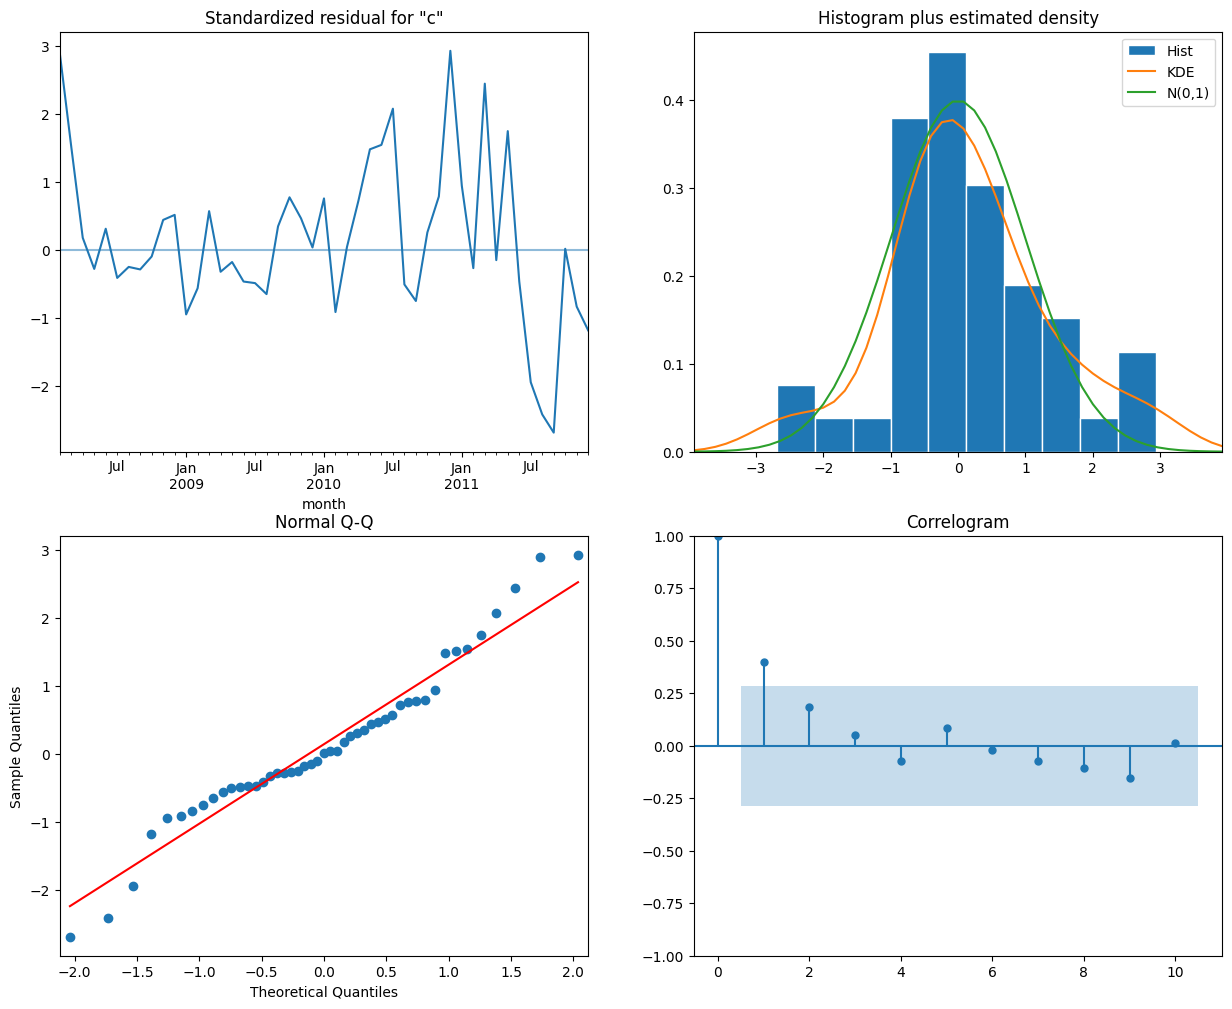

In [31]:
import statsmodels.api as sm

#data_train.index = data_train.index.to_period('M')
solar_order = (10,1,0) # These capture the auto-regressive, integrated and moving average components of the model, respectively.
solar_seasonal_order = (1,1,1,12)
model = sm.tsa.statespace.SARIMAX(data_train, order = solar_order, seasonal_order = solar_seasonal_order)
results = model.fit()

print(round(results.aic,2))
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()
               

In [57]:
# Get forecast 
pd.plotting.register_matplotlib_converters()
pred_uc = results.get_forecast(steps=12)
predictions = pred_uc.predicted_mean
predictions.name = 'predictions'
predictions.head()

2012-01    1.586818e+06
2012-02    1.543124e+06
2012-03    1.767063e+06
2012-04    1.867772e+06
2012-05    2.141288e+06
Freq: M, Name: predictions, dtype: float64

In [61]:
predictions.index

PeriodIndex(['2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
             '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12'],
            dtype='period[M]')

In [64]:
type(predictions)

pandas.core.series.Series

In [66]:
predictions.index = pd.to_datetime(predictions.index)

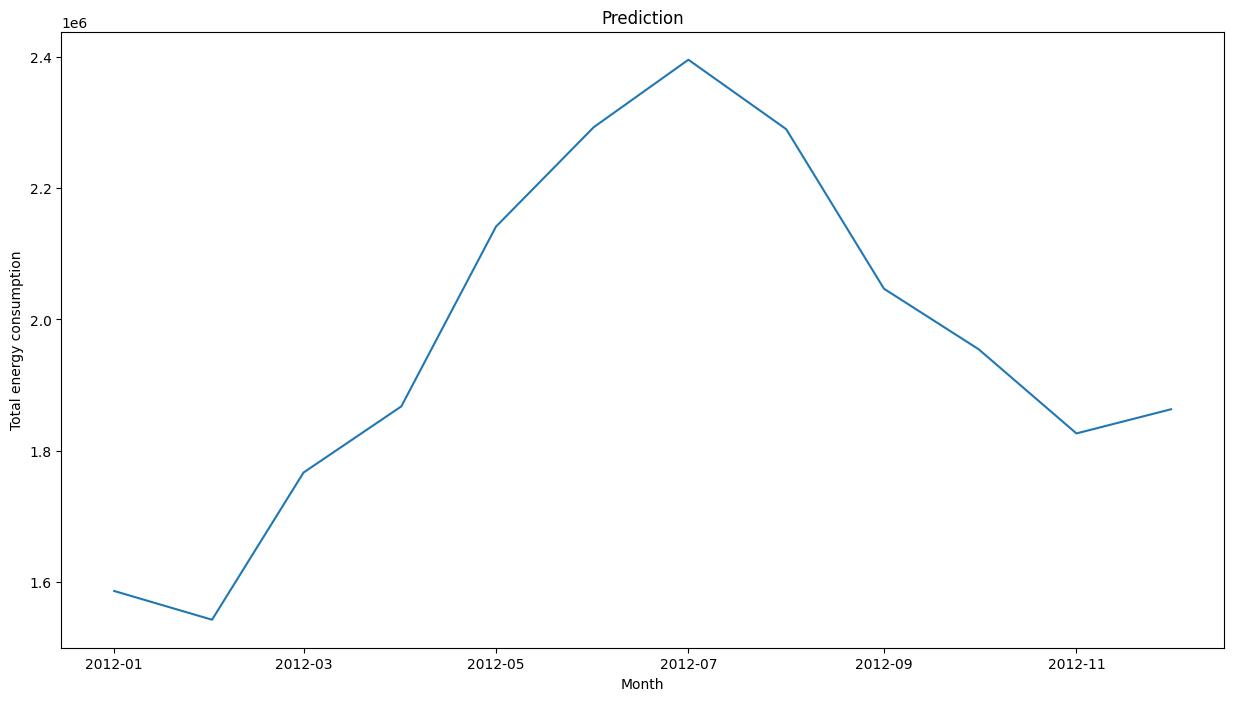

In [67]:
plt.rcParams['figure.figsize'] = [15, 8]

plt.plot(predictions)
plt.xlabel('Month')
plt.ylabel('Total energy consumption')
plt.title('Prediction')
plt.show()